In [1]:
from triqs.gf import *
from triqs.gf.tools import fit_legendre
import triqs.utility.mpi as mpi
from triqs.operators import *
from triqs_cthyb import Solver
from h5 import *
import numpy as np
import os.path
import sys
%matplotlib inline
from triqs.plot.mpl_interface import plt,oplot

Starting serial run at: 2024-06-27 12:08:07.573020


## Attractive Hubbard Model

The problem of superconductivity can be expressed by a Hubbard model such as those used in previous tutorials on antiferromagnetism. The temperature dependence is actually completely symetrical when using a negative U for superconductivity. In that sense, to minimize the energy, the interacting term, $H_{int} = Un_\uparrow n_\downarrow$ tend to favor the creation of Cooper pairs. It is the attractive potential as opposed to the repulsive potential. We know that at half filling (n=1), the Hamiltonian for the attractive hubbard model is completely symmetrical to the repulsive Hubbard model with the mapping:

\begin{equation}
H_U \rightarrow H_{-U} \\
c_\uparrow  \rightarrow c_\uparrow \\ c_\downarrow \rightarrow c_\downarrow^\dagger
\end{equation}

Which is done when using the Nambu formalism. Thus, we can use the same method than for Mott insulator to express superconductivity. 

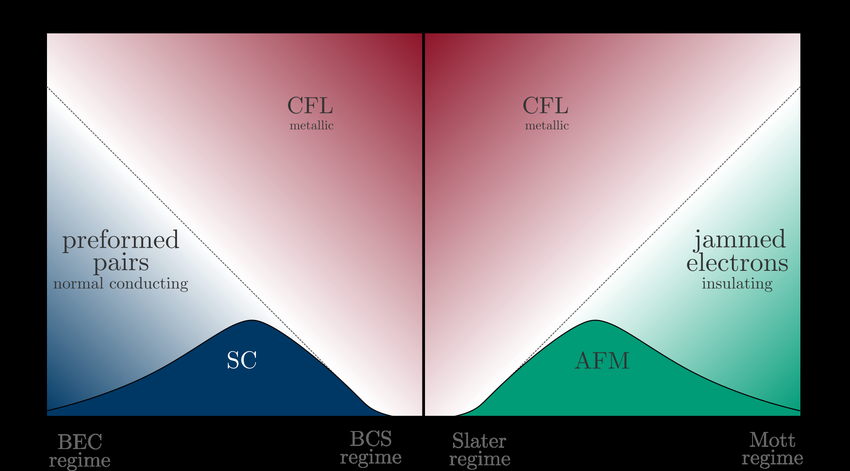!

https://www.researchgate.net/figure/Equilibrium-phase-diagram-of-the-three-dimensional-Hubbard-model-on-cubic-lattice-as-a_fig8_358145714 need to change that

We will then consider the derivative of F with regards to pair creation.

$$\frac{dF}{d\phi_{pp}}$$

# Nambu superconductivity model

The Nambu model of superconductivity allow  to visualize superconductivity phenomena through a 2x2 Green Function matrices. 

A Green function can be generaly written as 

$$G = -<T_\tau \psi(\tau) \psi \dagger>$$


Where we introduce the Nambu spinors: 
$$\psi = \begin{pmatrix}
    c_\uparrow \\
    c_\downarrow^\dagger
\end{pmatrix}
\quad
\psi^\dagger = \begin{bmatrix}
    c_\uparrow^\dagger & c_\downarrow
\end{bmatrix}$$



Which allow us to consider a Green function of the shape:

\begin{equation}
G = - \langle T \begin{pmatrix}
    c_{\uparrow} (\tau) c_{\uparrow}^\dagger & c_\downarrow (\tau) c_\uparrow \\
    c_\uparrow^\dagger (\tau) c_\downarrow^\dagger & c_\downarrow (\tau) c_\downarrow^\dagger 
\end{pmatrix} \rangle =  <\begin{pmatrix}
    g(\tau) & F(\tau) \\
    F(\tau)* & -g(-\tau)
\end{pmatrix}>
\end{equation}

We see that the g component represents the displacement of one electron/hole wereas the F component represents the displacement of two electrons/holes on our site, thus the Cooper pairs. As a Green function must be hermitian we will consider $F(\tau)=c_\downarrow (\tau) c_\uparrow= (c_\uparrow^\dagger (\tau) c_\downarrow^\dagger)^\dagger$. For a normal metal we thus consider $F(\tau)=0$ and for a superconductor $F(\tau)\neq 0$. $F(\tau)$ can be seen as a measure of interaction.

In its matrix form,the self-consistency equation will take the following form

\begin{equation}
{\cal G}_{\sigma}^{-1} (i\omega_n) = i\omega_n  + \mu \sigma_3 - t^2 \sigma_3 G_{ \sigma} (i\omega_n) \sigma_3
\end{equation}

With $\sigma_3$ a Pauli matrice $ \begin{pmatrix}
    1 & 0 \\
    0 & -1
\end{pmatrix}$

Considering the Hubbard model, the interaction hamiltonian is given by: $H_{int} = Un_\uparrow n_\downarrow=Uc_\uparrow^\dagger c_\uparrow c_\downarrow^\dagger c_\downarrow$. Which in term can be written in the Nambu formalism: 

$$U= \psi_0^\dagger \psi_0 \psi_1 \psi_1^\dagger$$

Superconductors exhibit a Higgs potential (also known as Mexican Hat Potential) which brings the need to break the symmetry before we start to conduct calculation else we will never reach superconductivity. To do that, let's add a very little number $\Delta_0$ to the off-diagonal $F(\tau)$ parameter.

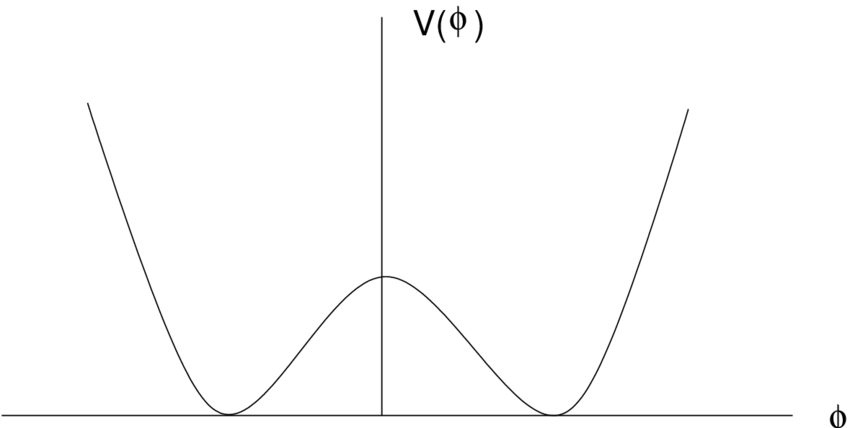!

Need to put the reference here

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1:
Finish the Nambu superconductor model below to obtain the Green function.Observe the difference between U>0 and U<0. Explore and try to remove the value of delta to see the effect.

In [ ]:
%%time
# Other parameters for the calculation


niter0 = 0
niter = 30   #nloop
t = 1
mixing = 0.7
Delta0 = 0.01 #partir 0.01


U=-4
beta=10
mu = U/2   #half filling
y=[]
n_iw = int(15*beta)     #À réduire
n_tau = int(100*beta)
# Interacting Hamiltonian in the Nambu basis
h_int = U * n('N', 0) * c('N', 1)*c_dag('N', 1)
p = {'n_warmup_cycles': 5000,      #Faire étude
             'n_cycles': 10000,#int(nc*np.abs(U)*beta/mpi.size)
             'random_seed': 123 * mpi.rank + 321,
             'length_cycle': int(20*beta),
             'measure_G_tau': True,
             # 'measure_density_matrix': True,
             'use_norm_as_weight': True,
             # 'perform_tail_fit': True,
             # 'fit_min_n': int(beta*2)+3,
             # 'fit_max_n': int(beta*4)+4,
             'imag_threshold': 1e-11,
             # 'fit_max_moment': 3,
    }
print("U = %.2f, Beta = %i" % (U, beta))


S = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', [0, 1])])   

# Symmetry breaking field
Sigma = S.G0_iw['N'].copy()
Sigma.zero()
Sigma[0, 1] << Delta0
Sigma[1, 0] << Delta0

########################################### From here erase for the exercise ###################################################################

# SemiCircular DOS
S.G0_iw['N'][0, 0] << SemiCircular(2*t)
S.G0_iw['N'][1, 1] = S.G0_iw['N'][0, 0].copy()
S.G0_iw['N'][1, 1] << -1 * S.G0_iw['N'][1, 1].conjugate()

# Inversion of the Green function
S.G_iw['N'] << inverse(inverse(S.G0_iw['N']) - Sigma)

for i in range(niter0, niter):
    print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))
    
      # Self-consistency relation
    S.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['N'][0, 0]
    S.G0_iw['N'][0, 1] << + t**2 * S.G_iw['N'][0, 1]
    S.G0_iw['N'][1, 0] << + t**2 * S.G_iw['N'][1, 0]
    S.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['N'][1, 1]
    S.G0_iw['N'].invert()
     # Save an older Green function for mixing after solve.
    old_G_iw = S.G_iw.copy()
    old_Sigma = S.Sigma_iw.copy()['N']
    S.solve(h_int = h_int, **p)

    # Mixing to avoid density fluctuations
    S.G_iw << mixing*S.G_iw + (1-mixing)*old_G_iw

    # Calculation of the self-energy
    Sigma = S.Sigma_iw['N']
    y+=[S.G_tau['N'][1,0][Idx(0)]]
    
    
    

U = -4.00, Beta = 10
########## Beta = 10.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
11:36:35   7% ETA 00:00:01 cycle 386 of 5000
11:36:36 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
11:36:36   4% ETA 00:00:02 cycle 405 of 10000
11:36:38  84% ETA 00:00:00 cycle 8460 of 10000
11:36:38 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.0036639 
Average order         | 0.000402575
Average sign          | 0.000340279
G_tau measure         | 0.0041807 
Total measure time    | 0.00858746
[Rank 0] Acceptan

TRIQS : Received signal 2
mc_generic: Signal caught on node 0



########## Beta = 10.00 ##### Iteration = 4

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
11:36:48   9% ETA 00:00:00 cycle 492 of 5000
11:36:49 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
11:36:49   4% ETA 00:00:01 cycle 495 of 10000
11:36:51 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00334788
Average order         | 0.000365565
Average sign          | 0.000342865
G_tau measure         | 0.00264316
Total measure time    | 0.00669947
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.0578476
  Mo

TRIQS : Received signal 2
mc_generic: Signal caught on node 0



########## Beta = 10.00 ##### Iteration = 6

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
11:36:54  10% ETA 00:00:00 cycle 503 of 5000
11:36:55 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
11:36:55   4% ETA 00:00:02 cycle 475 of 10000
11:36:57 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00337894
Average order         | 0.000370196
Average sign          | 0.00030628
G_tau measure         | 0.00264565
Total measure time    | 0.00670106
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.0569972
  Mov

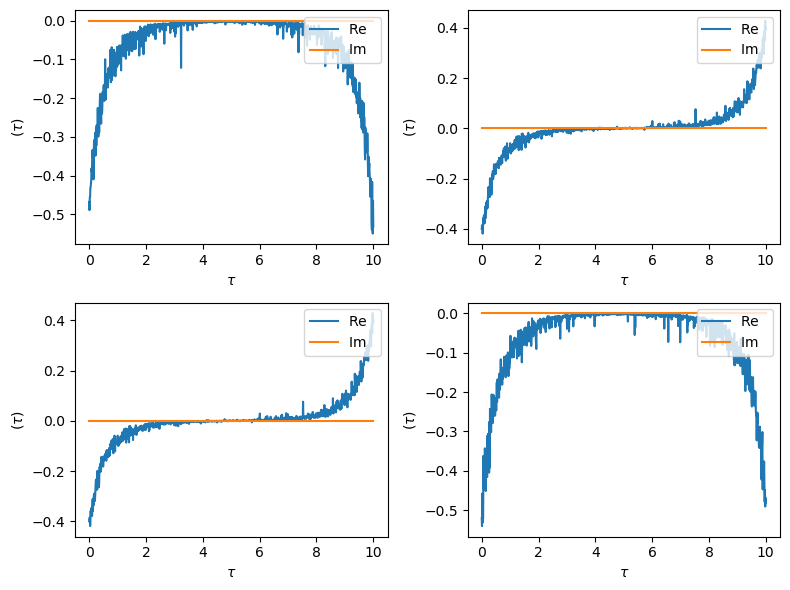

In [4]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)  # (rows, columns, panel number)
oplot(S.G_tau['N'][0,0])
plt.subplot(2, 2, 2)  # (rows, columns, panel number)
oplot(S.G_tau['N'][1,0])
plt.subplot(2, 2, 3)  # (rows, columns, panel number)
oplot(S.G_tau['N'][0,1])
plt.subplot(2, 2, 4)  # (rows, columns, panel number)
oplot(S.G_tau['N'][1,1])



plt.tight_layout()

/mnt/sw/nix/store/lq18vwc5g47301xpm32i8hx1z2n199bd-python-3.9.16-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


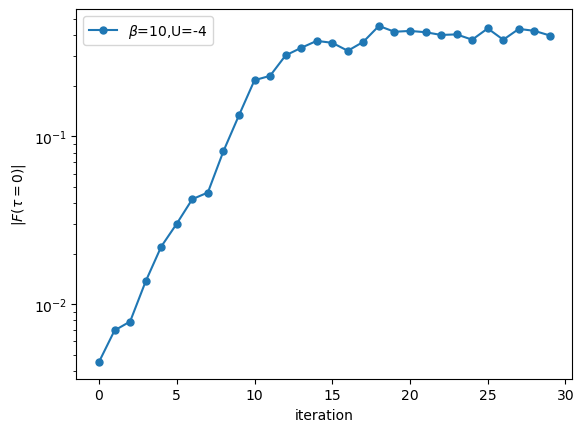

In [5]:
plt.semilogy(np.arange(niter0,niter,1),-1*np.array(y),label=rf'$\beta$={beta},U={U}',linestyle='-',marker='o',markersize=5)

plt.xlabel('iteration')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')
        

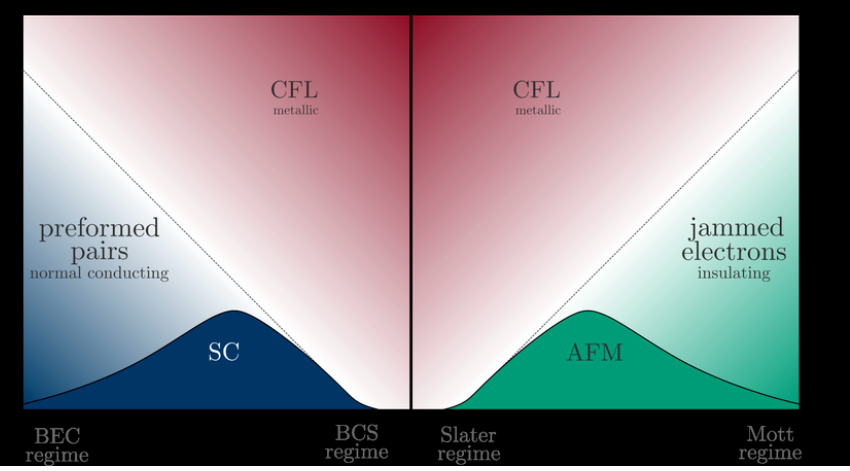

In [2]:
import os
import shutil

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2:

In [11]:
def DMFT(beta,U,n_cycles=10000,own_path="",niter0=0,niter=30):
    
    n_iw = int(15*beta)
    n_tau = int(100*beta)

    mixing=0.7
    mu = U/2 
    Delta0=0.005
    t=1
    # Interacting Hamiltonian in the Nambu basis
    h_int = U * n('N', 0) * c('N', 1)*c_dag('N', 1)
    p = {'n_warmup_cycles': 5000,#int(4000*beta),
                 'n_cycles': n_cycles,#int(nc*np.abs(U)*beta/mpi.size)
                 'random_seed': 123 * mpi.rank + 321,
                 'length_cycle': int(20*beta),
                 'measure_G_tau': True,
                 #'measure_density_matrix': True,
                 'use_norm_as_weight': True,
                 #'perform_tail_fit': True,
                 #'fit_min_n': int(beta*2)+3,
                 #'fit_max_n': int(beta*4)+4,
                 'imag_threshold': 1e-11,
                 #'fit_max_moment': 3
        }
    print("U = %.2f, Beta = %i" % (U, beta))
    S2 = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', [0, 1])])    #Possiblement [('N',2)]
    # Symmetry breaking field
    Sigma = S2.G0_iw['N'].copy()
    Sigma.zero()
    Sigma[0, 1] << Delta0
    Sigma[1, 0] << Delta0

    # SemiCircular DOS
    S2.G0_iw['N'][0, 0] << SemiCircular(2*t)
    S2.G0_iw['N'][1, 1] = S2.G0_iw['N'][0, 0].copy()
    S2.G0_iw['N'][1, 1] << -1 * S2.G0_iw['N'][1, 1].conjugate()

    # Inversion of the Green function
    S2.G_iw['N'] << inverse(inverse(S2.G0_iw['N']) - Sigma)
    
    if own_path=="":
        path=f"h5_b{beta}_U{U}_j2"
    else:
        path=own_path
    
    
    
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
            print(f"Directory '{path}' removed.")
        except OSError as error:
            print(f"Error removing directory '{path}': {error}")


    try:
        os.makedirs(path)
        print(f"Directory '{path}' created successfully.")
    except OSError as error:
        print(f"Directory '{path}' creation failed: {error}")


    for i in range(niter0, niter):
        print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))

          # Self-consistency relation
        S2.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S2.G_iw['N'][0, 0]
        S2.G0_iw['N'][0, 1] << + t**2 * S2.G_iw['N'][0, 1]
        S2.G0_iw['N'][1, 0] << + t**2 * S2.G_iw['N'][1, 0]
        S2.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S2.G_iw['N'][1, 1]
        S2.G0_iw['N'].invert()
         # Save an older Green function for mixing after solve.
        old_G_iw = S2.G_iw.copy()
        old_Sigma = S2.Sigma_iw.copy()['N']
        S2.solve(h_int = h_int, **p)
        print("now now here")
        # Mixing to avoid density fluctuations
        S2.G_iw << mixing*S2.G_iw + (1-mixing)*old_G_iw

        # Calculation of the self-energy
        Sigma = S2.Sigma_iw['N']
        with HDFArchive(f"{path}/Solver-b{beta}-U{U}-i{i}.h5", 'w') as arch: arch[f"Solver-b{beta}-U{U}-i{i}"] = S2 
        
    return S2.G_tau['N'][1,0][Idx(0)]

In [12]:
%%time
betas=[2,3,4,5,6,8,10]
U=-4
niter=30
for beta in betas:
    path=f"h5_U{U}_b{beta}"
    DMFT(beta=beta,U=U, niter=niter,own_path=path)



U = -4.00, Beta = 2
Directory 'h5_U-4_b2' removed.
Directory 'h5_U-4_b2' created successfully.
########## Beta = 2.00 ##### Iteration = 0
now now here

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:17:15  52% ETA 00:00:00 cycle 2632 of 5000
12:17:15 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
12:17:15  25% ETA 00:00:00 cycle 2569 of 10000
12:17:15 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00325391
Average order         | 0.000378716
Average sign          | 0.000356808
G_tau measure         | 0.00094963
Total measu

## Evolution of the Green off-diagonal

/mnt/sw/nix/store/lq18vwc5g47301xpm32i8hx1z2n199bd-python-3.9.16-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


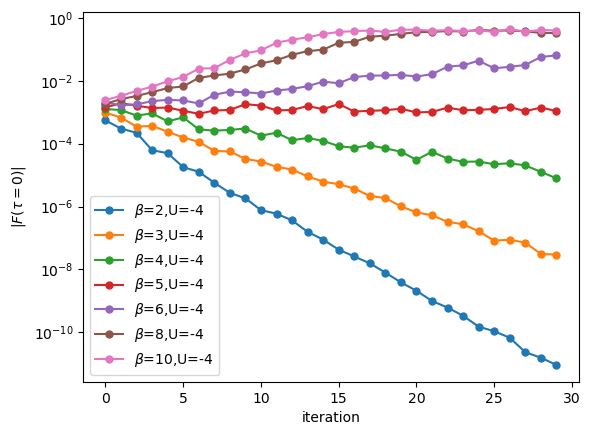

In [13]:
niter0=0
for beta in betas:
    y=[]
    path=f"h5_U{U}_b{beta}"
    for i in range(niter0,niter):
        with HDFArchive(f"{path}/Solver-b{beta}-U{U}-i{i}.h5","r") as R:
            S_ = R[f"Solver-b{beta}-U{U}-i{i}"]
        y+=[S_.G_tau['N'][1,0][Idx(0)]]

    plt.semilogy(np.arange(niter0,niter,1),-1*np.array(y),label=rf'$\beta$={beta},U={U}',linestyle='-',marker='o',markersize=5)
plt.xlabel('iteration')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')

We see that every time we run the DFT the $F(\tau)$ is converging to a value. If the material is not superconducting then it converges to zero but when ti is superconducting it converges to 0.5 (half filling). When the curves are converging indicates the moment superconductivity is hit.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2:

Now verify the impact of multiple U on the critical temperature for superconductivity.

In [14]:
%%time
Us=[-3,-4,-5]
betas=[3,4,5,6,7,8,9,10]
niter=20
for U in Us:
    for beta in betas:
        path=f"h5_U{U}_b{beta}"
        DMFT(beta=beta,U=U, niter=niter,own_path=path)

U = -3.00, Beta = 3
Directory 'h5_U-3_b3' removed.
Directory 'h5_U-3_b3' created successfully.
########## Beta = 3.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1.5*c_dag('N',0)*c('N',0) + -1.5*c_dag('N',1)*c('N',1) + 3*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:23:29  30% ETA 00:00:00 cycle 1502 of 5000
12:23:29 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
12:23:29  15% ETA 00:00:00 cycle 1589 of 10000
12:23:29 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00301625
Average order         | 0.000375758
Average sign          | 0.000285909
G_tau measure         | 0.00117261
Total measure time  

## U dependence

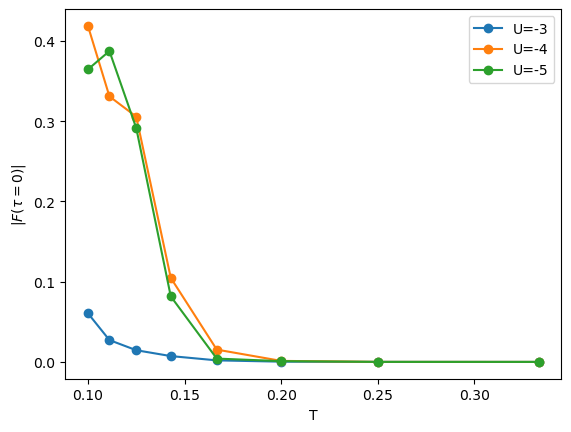

In [16]:
for U in Us:
    y2=[]
    for beta in betas:
   
        path=f"h5_U{U}_b{beta}"
        with HDFArchive(f"{path}/Solver-b{beta}-U{U}-i{niter-1}.h5","r") as R:
            S = R[f"Solver-b{beta}-U{U}-i{niter-1}"]
        y2+=[S.G_tau['N'][1,0][Idx(0)]]

    
    plt.plot(1/np.array(betas),-1*np.array(y2),marker='o',label=f'U={U}')
plt.xlabel('T')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')

Superconductivity is reached when $F(\tau)$ is non zero. U=-4 is optimal to obtain superconductivity as it has the highest critical temperature. 

In [10]:
DMFT(beta=4,U=-4,niter=30)
DMFT(beta=5,U=-4,niter=30)
DMFT(beta=6,U=-4,niter=30)

U = -4.00, Beta = 4
Directory 'h5_b4_U-4_j2' removed.
Directory 'h5_b4_U-4_j2' created successfully.
########## Beta = 4.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
now now here-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:14:32  23% ETA 00:00:00 cycle 1160 of 5000
12:14:33 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
12:14:33  11% ETA 00:00:00 cycle 1112 of 10000
12:14:34 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00331272
Average order         | 0.000362111
Average sign          | 0.000353365
G_tau measure         | 0.0015861 
Total 

TRIQS : Received signal 2
mc_generic: Signal caught on node 0



[Rank 0] Simulation lasted: 1.10142 seconds [00:00:01]
[Rank 0] Number of measures: 10000
Total number of measures: 10000
Average sign: 1
Average order: 2.3229
Auto-correlation time: 0.193256

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:16:22  17% ETA 00:00:00 cycle 898 of 5000
12:16:22 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
12:16:22   9% ETA 00:00:00 cycle 924 of 10000
mc_generic stops because of a signal


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.0030352 
Average order         | 0.000350869
Average sign          | 0.00032136
G_tau measure     

(-0.10870623600974708+0j)